In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_recall_fscore_support, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split

load_dotenv()

True

In [10]:
# configuration
RANDOM_STATE = int(os.environ.get("RANDOM_STATE"))
UNCERTAIN_AS_1 = True  # how to handle Uncertain responses: True -> 1, False -> 0.5
RESULTS_DIR = os.environ.get("RESULTS_DIR")

# plotting style
plt.style.use("default")
sns.set_palette("husl")

# 1. Data Import and Preparation

In [11]:
df = pd.read_csv("../data/results_alessandro.csv", index_col=0)
df.head(5)

,label,ti_ab,title,abstract,journal_title,authors,Publication_Year,DOI,Volume,Pages,...,is_delusional_disorder,is_persistent_hallucinations,is_at_risk_of_psychosis,is_serious_mental_illness,is_dual_diagnosis,is_relatives_caregivers,is_stigma_or_education_focused,final_decision,reasoning,force_include_reason
ID,,,,,,,,,,,,,,,,,,,,,
0,False,False,"""Cognitive Assessment in Psychiatric Patients ...",Background: Electroconvulsive treatment (ECT) ...,European Journal of Cardiovascular Medicine,"Sharma, V.; Gade, V.; Rajeev, A.; Saudam, M.; ...",2023,NaN,13(4),924-935,...,Uncertain,No,No,Uncertain,Uncertain,No,No,Exclude,Evaluated by logic,NaN
1,True,True,"""Comparison of the impact of peer education an...","Inclusion criteria: ""All patients with psychia...",https://irct.behdasht.gov.ir/trial/80261,IRCT20241108063635N1,2024,NaN,NaN,NaN,...,No,No,No,No,Uncertain,No,No,Include,Force include: brain_stimulation_with_schiz_terms,brain_stimulation_with_schiz_terms
2,True,True,"""Comparison of two Anaesthesia Drugs Thiopenta...",Inclusion criteria: ASA 1 and 2 patients sched...,http://www.ctri.nic.in/Clinicaltrials/pmaindet...,CTRI/2024/09/073405,2024,NaN,NaN,NaN,...,No,No,No,No,No,No,No,Include,Force include: brain_stimulation_with_schiz_terms,brain_stimulation_with_schiz_terms
3,False,False,"""Efficacy of intensive bilateral Temporo-Parie...",Transcranial magnetic stimulation (TMS) is a n...,Asian Journal of Psychiatry,"Tyagi, Priya; Dhyani, Mohan; Khattri, Sumit; T...",2022,NaN,74,1-7,...,No,Uncertain,No,No,No,No,No,Include,Force include: trial_registry_title,trial_registry_title
4,False,False,"""Empowering Hope: Non-Pharmacological Interven...",<b>Aim</b>: Borderline personality disorder (B...,Journal of multidisciplinary healthcare,"Maulana, I.; Suryani, S.; Sriati, A.; Yosep, I...",2024,NaN,17,4603-4609,...,No,No,No,No,No,No,No,Exclude,Excluded in screening: is_systematic_review,NaN


## Feature and Label Extraction

In [12]:
features_cols = [
    "is_animal_study",
    "is_systematic_review",
    "is_case_report",
    "is_purely_retraction_notice",
    "is_healthy_volunteers_study",
    "is_clear_single_arm_study",
    "is_affective_psychosis_only",
    "is_observational_non_interventional",
    "is_qualitative_only",
    "is_rct_or_cct",
    "has_trial_or_registry_signal",
    "is_interventional_signal",
    "is_schizophrenia",
    "is_brain_stimulation",
    "is_non_affective_psychotic_disorder",
    "is_schizoaffective_disorder",
    "is_schizophreniform",
    "is_schizotypy",
    "is_akathisia",
    "is_tardive_dyskinesia",
    "is_delusional_disorder",
    "is_persistent_hallucinations",
    "is_at_risk_of_psychosis",
    "is_serious_mental_illness",
    "is_dual_diagnosis",
    "is_relatives_caregivers",
    "is_stigma_or_education_focused",
]

label_col = "label"

In [13]:
def convert_yes_no_uncertain_to_int(value: str, uncertain_as_1: bool) -> int:
    """convert Yes/No/Uncertain to binary
    No -> 0
    Yes -> 1
    Uncertain -> 1 if uncertain_as_1 is True, else 0.5"""
    if value == "No":
        return 0
    elif value == "Yes":
        return 1
    elif value == "Uncertain":
        return 1 if uncertain_as_1 else 0.5
    else:
        raise ValueError(f"Unexpected value: {value}")

# 2. Data Quality Analysis

## Data Consistency Check

Identify papers with identical features but different labels.

In [14]:
# Convert features for analysis (temporary df)
df_temp = df.copy()
for col in features_cols:
    df_temp[col] = df_temp[col].apply(convert_yes_no_uncertain_to_int, uncertain_as_1=UNCERTAIN_AS_1)

# Find duplicates with different labels
duplicates = df_temp.groupby(features_cols).filter(lambda x: len(x) > 1 and x["label"].nunique() > 1)

if len(duplicates) > 0:
    print(f"Found {len(duplicates)} papers with identical features but different labels")
    duplicates_sorted = duplicates[["label"] + features_cols].sort_values(by=features_cols)
    display(duplicates_sorted.head(20))
else:
    print("No papers with identical features but different labels found")

Found 2022 papers with identical features but different labels


,label,is_animal_study,is_systematic_review,is_case_report,is_purely_retraction_notice,is_healthy_volunteers_study,is_clear_single_arm_study,is_affective_psychosis_only,is_observational_non_interventional,is_qualitative_only,...,is_schizotypy,is_akathisia,is_tardive_dyskinesia,is_delusional_disorder,is_persistent_hallucinations,is_at_risk_of_psychosis,is_serious_mental_illness,is_dual_diagnosis,is_relatives_caregivers,is_stigma_or_education_focused
ID,,,,,,,,,,,,,,,,,,,,,
609,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3077,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3516,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3822,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4392,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4907,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
640,False,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2061,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5573,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## LLM Response Quality: Uncertain Rates

In [15]:
UNCERTAIN_RATE_MAX = 15  # maximum percentage of Uncertain responses allowed per feature

In [16]:
# Analyze Uncertain responses to identify confusing features
uncertain_counts = {}
for col in features_cols:
    uncertain_pct = (df[col] == "Uncertain").sum() / len(df) * 100
    uncertain_counts[col] = uncertain_pct

uncertain_df = pd.DataFrame(list(uncertain_counts.items()), columns=["Feature", "Uncertain %"]).sort_values("Uncertain %", ascending=False)

print("Features with Uncertain rates:")
display(uncertain_df.round(1))

# Identify features with high Uncertain responses
high_uncertain_features = uncertain_df[uncertain_df["Uncertain %"] > UNCERTAIN_RATE_MAX]["Feature"].tolist()
if len(high_uncertain_features) > 0:
    print(f"\n{len(high_uncertain_features)} features have >{UNCERTAIN_RATE_MAX}% Uncertain responses:")
    print(high_uncertain_features)
else:
    print(f"\nNo features have >{UNCERTAIN_RATE_MAX}% Uncertain responses")

Features with Uncertain rates:


,Feature,Uncertain %
9,is_rct_or_cct,22.9
11,is_interventional_signal,11.1
7,is_observational_non_interventional,10.0
14,is_non_affective_psychotic_disorder,9.5
21,is_persistent_hallucinations,8.8
10,has_trial_or_registry_signal,7.7
23,is_serious_mental_illness,7.0
12,is_schizophrenia,6.3
5,is_clear_single_arm_study,5.5
24,is_dual_diagnosis,4.2



1 features have >15% Uncertain responses:
['is_rct_or_cct']


# 3. Data Preprocessing

In [17]:
df_processed = df.copy()

# Convert feature columns to numeric
for col in features_cols:
    df_processed[col] = df_processed[col].apply(convert_yes_no_uncertain_to_int, uncertain_as_1=UNCERTAIN_AS_1)

# Prepare X (features) and y (labels)
X = df_processed[features_cols]
y = df_processed[label_col]

print(f"Dataset shape: {X.shape}")
print(f"\nClass distribution:")
print(y.value_counts(normalize=True).round(2))

Dataset shape: (5747, 27)

Class distribution:
label
False    0.93
True     0.07
Name: proportion, dtype: float64


In [18]:
# Train/Validation/Test split: 60% / 20% / 20%
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_full)

print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

Train: 3447 (60.0%)
Val:   1150 (20.0%)
Test:  1150 (20.0%)


# 4. Model Training

In [19]:
# Initial Random Forest with default hyperparameters
rf_classifier = RandomForestClassifier(
    n_estimators=500,
    random_state=RANDOM_STATE,
    class_weight="balanced",  # Handle class imbalance
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
)

rf_classifier.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [20]:
# Helper function for specificity calculation
def specificity_score(y_true, y_pred):
    """Calculate specificity (True Negative Rate)"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)


specificity_scorer = make_scorer(specificity_score)

In [21]:
# Cross-validation setup
N_FOLDS = 5
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

In [22]:
# Evaluate with cross-validation
cv_scores_accuracy = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring="accuracy")
cv_scores_precision = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring="precision")
cv_scores_recall = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring="recall")
cv_scores_specificity = cross_val_score(rf_classifier, X_train, y_train, cv=cv, scoring=specificity_scorer)

train_metrics_df = (
    pd.DataFrame(
        {
            "metric": ["accuracy", "precision", "recall", "specificity"],
            f"mean over {N_FOLDS} folds": [
                cv_scores_accuracy.mean(),
                cv_scores_precision.mean(),
                cv_scores_recall.mean(),
                cv_scores_specificity.mean(),
            ],
        }
    )
    .set_index("metric")
    .round(2)
)

print("CROSS-VALIDATION RESULTS (Train Set)")
display(train_metrics_df)

CROSS-VALIDATION RESULTS (Train Set)


,mean over 5 folds
metric,
accuracy,0.92
precision,0.44
recall,0.75
specificity,0.93


## Initial Test Set Evaluation

In [23]:
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
precision, recall, _, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
test_specificity = specificity_score(y_test, y_pred)

test_metrics_df = (
    pd.DataFrame(
        {
            "metric": ["accuracy", "precision", "recall", "specificity"],
            "test set": [test_accuracy, precision, recall, test_specificity],
        }
    )
    .set_index("metric")
    .round(2)
)

print("TEST SET RESULTS (Default Classifier)")
display(test_metrics_df)

TEST SET RESULTS (Default Classifier)


,test set
metric,
accuracy,0.93
precision,0.47
recall,0.82
specificity,0.94


In [24]:
# Feature importance
feature_importance = (
    pd.DataFrame(
        {
            "feature": features_cols,
            "importance": rf_classifier.feature_importances_,
        }
    )
    .sort_values("importance", ascending=False)
    .set_index("feature")
    .round(2)
)

print("Top 5 Most Important Features:")
display(feature_importance.head(5))

print(f"Top 5 features account for {feature_importance.head(5)['importance'].sum():.1%} of total importance")
print(f"Top 10 features account for {feature_importance.head(10)['importance'].sum():.1%} of total importance")

Top 5 Most Important Features:


,importance
feature,
is_non_affective_psychotic_disorder,0.25
has_trial_or_registry_signal,0.16
is_schizophrenia,0.11
is_rct_or_cct,0.10
is_observational_non_interventional,0.06


Top 5 features account for 68.0% of total importance
Top 10 features account for 85.0% of total importance


# 5. Hyperparameter Tuning

### Grid search

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [2, 3],
    "bootstrap": [True, False],
}

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "specificity": specificity_scorer,
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1),
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    refit="recall",  # choose metric to optimize for final estimator
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV (refit metric - recall) score:", grid_search.best_score_)

best_rf_gs = grid_search.best_estimator_
best_rf_gs

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See http

Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best CV (refit metric - recall) score: 0.916135265700483


,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [26]:
y_pred_gs = best_rf_gs.predict(X_test)
precision_gs, recall_gs, _, _ = precision_recall_fscore_support(y_test, y_pred_gs, average="binary")

print(f"Grid Search - Test Set: Precision = {precision_gs:.2f}, Recall = {recall_gs:.2f}")

Grid Search - Test Set: Precision = 0.41, Recall = 0.95


### Random search

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "n_estimators": [100, 200, 350, 500],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4],
    "bootstrap": [True, False],
}

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "specificity": specificity_scorer,
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=40,
    cv=cv,
    scoring=scoring,
    refit="recall",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
)
random_search.fit(X_train, y_train)

print("Best Parameters (random search):", random_search.best_params_)
print("Best CV (refit metric - recall) score:", random_search.best_score_.round(3))

best_rf_rnd = random_search.best_estimator_
best_rf_rnd

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters (random search): {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 5, 'bootstrap': False}
Best CV (refit metric - recall) score: 0.93


,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,4
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [29]:
y_pred_rnd = best_rf_rnd.predict(X_test)
precision_rnd, recall_rnd, _, _ = precision_recall_fscore_support(y_test, y_pred_rnd, average="binary")

print(f"Random Search - Test Set: Precision = {precision_rnd:.2f}, Recall = {recall_rnd:.2f}")

Random Search - Test Set: Precision = 0.34, Recall = 0.95


# 6. Threshold Tuning for 95%+ Recall

In [30]:
# Use best model from randomized search
classifier = best_rf_rnd
print(classifier)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=5,
                       min_samples_leaf=3, min_samples_split=4,
                       n_estimators=200, n_jobs=-1, random_state=42)


In [31]:
# Tune threshold on validation set to achieve 95%+ recall
y_val_proba = classifier.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.05, 0.55, 0.05)

recall_threshold_results = []
for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)

    accuracy_thresh = accuracy_score(y_val, y_val_pred)
    precision_thresh, recall_thresh, _, _ = precision_recall_fscore_support(y_val, y_val_pred, average="binary")
    specificity_thresh = specificity_score(y_val, y_val_pred)

    recall_threshold_results.append(
        {
            "threshold": threshold,
            "accuracy": accuracy_thresh,
            "precision": precision_thresh,
            "recall": recall_thresh,
            "specificity": specificity_thresh,
        }
    )

recall_threshold_df = pd.DataFrame(recall_threshold_results).set_index("threshold").round(3)
display(recall_threshold_df)

# Find threshold achieving 95%+ recall with best precision
recall_95_thresholds = recall_threshold_df[recall_threshold_df["recall"] >= 0.95]
if len(recall_95_thresholds) > 0:
    best_threshold_95 = recall_95_thresholds["precision"].idxmax()
    print(f"Selected threshold: {best_threshold_95:.2f}")
    print(f"Validation recall: {recall_95_thresholds.loc[best_threshold_95, 'recall']:.1%}")
    print(f"Validation precision: {recall_95_thresholds.loc[best_threshold_95, 'precision']:.1%}")
else:
    best_threshold_95 = recall_threshold_df["recall"].idxmax()
    print(f"\nNo threshold achieves 95% recall. Using threshold with highest recall: {best_threshold_95:.2f}")

,accuracy,precision,recall,specificity
threshold,,,,
0.05,0.317,0.087,0.987,0.269
0.10,0.457,0.107,0.987,0.419
0.15,0.533,0.122,0.974,0.502
0.20,0.752,0.207,0.974,0.736
0.25,0.789,0.233,0.961,0.777
0.30,0.805,0.248,0.961,0.794
0.35,0.815,0.258,0.961,0.804
0.40,0.842,0.290,0.961,0.833
0.45,0.851,0.301,0.947,0.845


Selected threshold: 0.40
Validation recall: 96.1%
Validation precision: 29.0%


In [32]:
# Final evaluation on test set with chosen threshold
y_test_proba = classifier.predict_proba(X_test)[:, 1]
y_test_pred_final = (y_test_proba >= best_threshold_95).astype(int)

final_recall = recall_score(y_test, y_test_pred_final)
final_precision = precision_score(y_test, y_test_pred_final)
final_accuracy = accuracy_score(y_test, y_test_pred_final)
final_specificity = specificity_score(y_test, y_test_pred_final)

print(f"FINAL TEST SET EVALUATION (threshold={best_threshold_95:.2f}):")
print(f"Recall:      {final_recall:.1%}")
print(f"Precision:   {final_precision:.1%}")
print(f"Accuracy:    {final_accuracy:.1%}")
print(f"Specificity: {final_specificity:.1%}")

workload_reduction = 1 - (y_test_pred_final.sum() / len(y_test))
print(f"\nWorkload Reduction: {workload_reduction:.1%}")
print(f"Papers to review: {y_test_pred_final.sum()} out of {len(y_test)}")

FINAL TEST SET EVALUATION (threshold=0.40):
Recall:      96.1%
Precision:   31.5%
Accuracy:    85.9%
Specificity: 85.2%

Workload Reduction: 79.8%
Papers to review: 232 out of 1150


Confusion Matrix:
                Predicted Negative  Predicted Positive
Actual Negative              915                 159
Actual Positive                3                  73



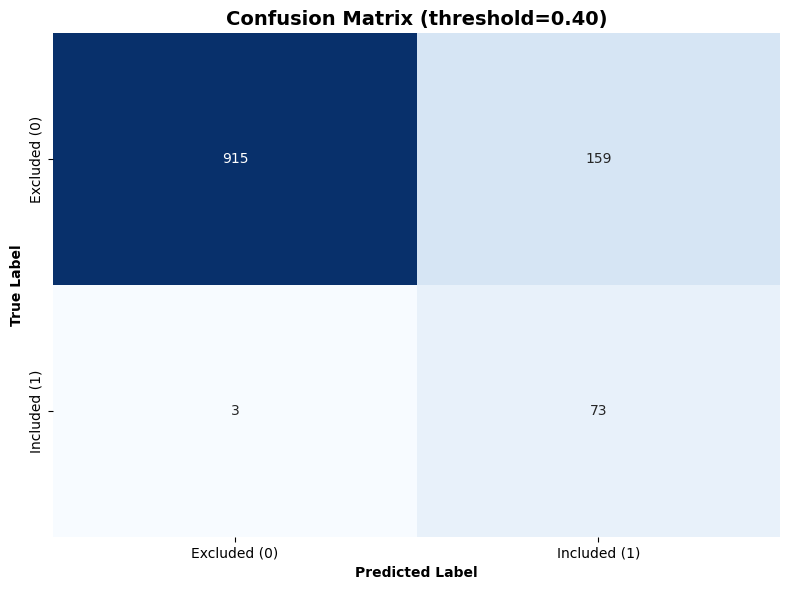


False Negatives: 3
These are papers that are actually INCLUDED but were predicted as EXCLUDED
False Negative Rate: 3.9% (this is 1 - Recall)

Top 10 False Negatives (ordered by decreasing probability):
(These were closest to being correctly classified)

  1. Index: 1032, Probability: 0.194
  2. Index: 4414, Probability: 0.186
  3. Index: 2918, Probability: 0.151


In [33]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred_final)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(f"{'':>15} Predicted Negative  Predicted Positive")
print(f"Actual Negative {tn:>16}  {fp:>18}")
print(f"Actual Positive {fn:>16}  {tp:>18}")
print()

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Excluded (0)", "Included (1)"],
    yticklabels=["Excluded (0)", "Included (1)"],
    ax=ax,
)
ax.set_xlabel("Predicted Label", fontweight="bold")
ax.set_ylabel("True Label", fontweight="bold")
ax.set_title(f"Confusion Matrix (threshold={best_threshold_95:.2f})", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

# Print false negatives (papers incorrectly classified as excluded)
print(f"\nFalse Negatives: {fn}")
print(f"These are papers that are actually INCLUDED but were predicted as EXCLUDED")
print(f"False Negative Rate: {fn / (tp + fn):.1%} (this is 1 - Recall)")
print()

# Get the indices of false negatives and their probabilities
fn_mask = (y_test == True) & (y_test_pred_final == 0)
fn_indices = y_test[fn_mask].index

if len(fn_indices) > 0:
    # Build a dataframe with index and probability for false negatives
    fn_data = []
    for idx in fn_indices:
        prob = y_test_proba[y_test.index.get_loc(idx)]
        fn_data.append({"index": idx, "probability": prob})

    fn_df = pd.DataFrame(fn_data).sort_values("probability", ascending=False)

    print(f"Top 10 False Negatives (ordered by decreasing probability):")
    print("(These were closest to being correctly classified)")
    print()
    for i, row in enumerate(fn_df.head(10).itertuples(), 1):
        print(f"  {i}. Index: {row.index}, Probability: {row.probability:.3f}")

    if len(fn_df) > 10:
        print(f"\n  ... and {len(fn_df) - 10} more false negatives")
else:
    print("No false negatives found!")

# 7. Re-evaluation with Filtered Features

Remove features with high Uncertain rates.

In [34]:
# Identify features to remove (high Uncertain rate)
features_to_remove = high_uncertain_features
features_filtered = [f for f in features_cols if f not in features_to_remove]

print(f"Original features: {len(features_cols)}")
print(f"Features to remove: {len(features_to_remove)}")
print(f"  - High Uncertain (>{UNCERTAIN_RATE_MAX}%): {high_uncertain_features}")
print(f"Filtered features: {len(features_filtered)}")

# Prepare filtered dataset
X_filtered = df_processed[features_filtered]
y_filtered = df_processed[label_col]

# Split data
X_train_full_f, X_test_f, y_train_full_f, y_test_f = train_test_split(
    X_filtered, y_filtered, test_size=0.20, random_state=RANDOM_STATE, stratify=y_filtered
)

X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(
    X_train_full_f, y_train_full_f, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_full_f
)

Original features: 27
Features to remove: 1
  - High Uncertain (>15%): ['is_rct_or_cct']
Filtered features: 26


In [35]:
# Train filtered model with best hyperparameters from random search
classifier_filtered = RandomForestClassifier(**random_search.best_params_, random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1)
classifier_filtered.fit(X_train_f, y_train_f)

print("Model trained on filtered features")

Model trained on filtered features


In [36]:
# Tune threshold on validation set
y_val_proba_f = classifier_filtered.predict_proba(X_val_f)[:, 1]

recall_threshold_results_f = []
for threshold in thresholds:
    y_val_pred_f = (y_val_proba_f >= threshold).astype(int)

    precision_f, recall_f, _, _ = precision_recall_fscore_support(y_val_f, y_val_pred_f, average="binary")

    recall_threshold_results_f.append(
        {
            "threshold": threshold,
            "precision": precision_f,
            "recall": recall_f,
        }
    )

recall_threshold_df_f = pd.DataFrame(recall_threshold_results_f).set_index("threshold").round(3)

recall_95_f = recall_threshold_df_f[recall_threshold_df_f["recall"] >= 0.95]
if len(recall_95_f) > 0:
    best_threshold_f = recall_95_f["precision"].idxmax()
    print(f"Selected threshold: {best_threshold_f:.2f}")
    print(f"Validation recall: {recall_95_f.loc[best_threshold_f, 'recall']:.1%}")
    print(f"Validation precision: {recall_95_f.loc[best_threshold_f, 'precision']:.1%}")
else:
    best_threshold_f = recall_threshold_df_f["recall"].idxmax()
    print(f"Using threshold with highest recall: {best_threshold_f:.2f}")

Selected threshold: 0.45
Validation recall: 96.1%
Validation precision: 30.5%


In [37]:
# Final evaluation on test set with filtered features
y_test_proba_f = classifier_filtered.predict_proba(X_test_f)[:, 1]
y_test_pred_f = (y_test_proba_f >= best_threshold_f).astype(int)

final_recall_f = recall_score(y_test_f, y_test_pred_f)
final_precision_f = precision_score(y_test_f, y_test_pred_f)
final_accuracy_f = accuracy_score(y_test_f, y_test_pred_f)
final_specificity_f = specificity_score(y_test_f, y_test_pred_f)

print(f"\nFINAL TEST SET EVALUATION (Filtered Features, threshold={best_threshold_f:.2f}):")
print(f"Recall:      {final_recall_f:.1%}")
print(f"Precision:   {final_precision_f:.1%}")
print(f"Accuracy:    {final_accuracy_f:.1%}")
print(f"Specificity: {final_specificity_f:.1%}")

workload_reduction_f = 1 - (y_test_pred_f.sum() / len(y_test_f))
print(f"\nWorkload Reduction: {workload_reduction_f:.1%}")
print(f"Papers to review: {y_test_pred_f.sum()} out of {len(y_test_f)}")


FINAL TEST SET EVALUATION (Filtered Features, threshold=0.45):
Recall:      96.1%
Precision:   32.4%
Accuracy:    86.5%
Specificity: 85.8%

Workload Reduction: 80.4%
Papers to review: 225 out of 1150


## Comparison: All Features vs Filtered Features

In [38]:
comparison_df = pd.DataFrame(
    {
        "All Features": [final_recall, final_precision, final_accuracy, final_specificity],
        "Filtered Features": [final_recall_f, final_precision_f, final_accuracy_f, final_specificity_f],
    },
    index=["Recall", "Precision", "Accuracy", "Specificity"],
).round(2)

print("COMPARISON: All Features vs Filtered Features")
display(comparison_df)

print(f"\nFeature count: {len(features_cols)} -> {len(features_filtered)} (removed {len(features_to_remove)})")
print(f"Recall change: {final_recall:.1%} -> {final_recall_f:.1%} ({(final_recall_f - final_recall)*100:+.1f} pp)")
print(f"Precision change: {final_precision:.1%} -> {final_precision_f:.1%} ({(final_precision_f - final_precision)*100:+.1f} pp)")

COMPARISON: All Features vs Filtered Features


,All Features,Filtered Features
Recall,0.96,0.96
Precision,0.31,0.32
Accuracy,0.86,0.87
Specificity,0.85,0.86



Feature count: 27 -> 26 (removed 1)
Recall change: 96.1% -> 96.1% (+0.0 pp)
Precision change: 31.5% -> 32.4% (+1.0 pp)


# 8. Strategies to Improve Recall

## 1. Remove Contradictory Observations
Papers with identical features but different labels add noise to training.

In [39]:
# Check for contradictory observations (identical features, different labels)
def resolve_conflicts(df_input, strategy="majority"):
    """
    Handle papers with identical features but different labels.

    Args:
        df_input: DataFrame with features and 'label' column
        strategy: 'remove' (drop all conflicts) or 'majority' (keep majority label)

    Returns:
        Cleaned DataFrame
    """
    feature_cols = features_cols

    if strategy == "remove":
        # Remove all papers with conflicting labels
        df_clean = df_input.groupby(feature_cols).filter(lambda x: x["label"].nunique() == 1)
    elif strategy == "majority":
        # Compute majority label per feature pattern
        def majority_label(series):
            counts = series.value_counts()
            if len(counts) == 1:
                return counts.index[0]
            # If tie, prefer True (to favor recall)
            if counts.iloc[0] == counts.iloc[1]:
                return True
            return counts.idxmax()

        maj = df_input.groupby(feature_cols, as_index=False)["label"].agg(majority_label).rename(columns={"label": "majority_label"})

        # Merge majority label back and keep only rows matching it
        df_merged = df_input.merge(maj, on=feature_cols, how="left")
        df_clean = df_merged[df_merged["label"] == df_merged["majority_label"]].drop(columns=["majority_label"])
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    return df_clean.reset_index(drop=True)


# Analyze conflicts
duplicates_check = df_temp.groupby(features_cols).filter(lambda x: len(x) > 1 and x["label"].nunique() > 1)

print(f"Dataset Analysis:")
print(f"Total papers: {len(df_temp)}")
print(f"Contradictory papers: {len(duplicates_check)} ({len(duplicates_check)/len(df_temp)*100:.1f}%)")
print(f"Unique feature patterns with conflicts: {duplicates_check.groupby(features_cols).ngroups}")
print(f"\nClass distribution:")
print(f"  Included: {df_temp['label'].sum()} ({df_temp['label'].sum()/len(df_temp)*100:.1f}%)")
print(f"  Excluded: {(~df_temp['label']).sum()} ({(~df_temp['label']).sum()/len(df_temp)*100:.1f}%)")

Dataset Analysis:
Total papers: 5747
Contradictory papers: 2022 (35.2%)
Unique feature patterns with conflicts: 69

Class distribution:
  Included: 379 (6.6%)
  Excluded: 5368 (93.4%)


In [40]:
# Compare strategies
df_removed = resolve_conflicts(df_temp, strategy="remove")
df_majority = resolve_conflicts(df_temp, strategy="majority")

print("Strategy Comparison:")
print(f"\nOriginal: {len(df_temp)} papers, {df_temp['label'].sum()} included")
print(f"\nRemove All Conflicts: {len(df_removed)} papers, {df_removed['label'].sum()} included")
print(f"  -> Removed: {len(df_temp) - len(df_removed)} papers")
print(f"  -> Class balance: {df_removed['label'].sum()/len(df_removed)*100:.1f}% included")
print(f"\nKeep Majority Label: {len(df_majority)} papers, {df_majority['label'].sum()} included")
print(f"  -> Removed: {len(df_temp) - len(df_majority)} papers")
print(f"  -> Class balance: {df_majority['label'].sum()/len(df_majority)*100:.1f}% included")
print("\nRecommendation: Use 'majority' strategy - removes only severely conflicting papers")

Strategy Comparison:

Original: 5747 papers, 379 included

Remove All Conflicts: 3725 papers, 91 included
  -> Removed: 2022 papers
  -> Class balance: 2.4% included

Keep Majority Label: 5505 papers, 216 included
  -> Removed: 242 papers
  -> Class balance: 3.9% included

Recommendation: Use 'majority' strategy - removes only severely conflicting papers


## 2. SMOTE (Synthetic Minority Over-sampling Technique)
Handle class imbalance by generating synthetic included papers.

In [41]:
from imblearn.over_sampling import SMOTE

# Use the ORIGINAL dataset (with conflicts) for splitting
# This ensures test set contains conflicting rows for realistic evaluation
X_original = df_temp[features_cols]
y_original = df_temp["label"]

# Split ORIGINAL data first - test set will contain conflicts
X_train_orig, X_temp_orig, y_train_orig, y_temp_orig = train_test_split(
    X_original, y_original, test_size=0.4, random_state=RANDOM_STATE, stratify=y_original
)
X_val_orig, X_test_orig, y_val_orig, y_test_orig = train_test_split(
    X_temp_orig, y_temp_orig, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp_orig
)

# Combine train + val for final training
X_train_full_orig = pd.concat([X_train_orig, X_val_orig])
y_train_full_orig = pd.concat([y_train_orig, y_val_orig])

print(f"Original dataset splits (test contains conflicts):")
print(f"  Train: {len(X_train_full_orig)} papers, {y_train_full_orig.sum()} included ({y_train_full_orig.sum()/len(X_train_full_orig)*100:.1f}%)")
print(f"  Test: {len(X_test_orig)} papers, {y_test_orig.sum()} included ({y_test_orig.sum()/len(X_test_orig)*100:.1f}%)")

# Now clean ONLY the training data using majority strategy
train_df = pd.DataFrame(X_train_full_orig)
train_df["label"] = y_train_full_orig.values
train_df_clean = resolve_conflicts(train_df, strategy="majority")

X_train_clean = train_df_clean[features_cols]
y_train_clean = train_df_clean["label"]

print(f"\nAfter cleaning ONLY training data:")
print(f"  Train (clean): {len(X_train_clean)} papers, {y_train_clean.sum()} included ({y_train_clean.sum()/len(X_train_clean)*100:.1f}%)")
print(f"  Removed from train: {len(X_train_full_orig) - len(X_train_clean)} conflicting papers")

# Train with SMOTE on cleaned training data
print("\nApplying SMOTE to cleaned training data...")
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_clean, y_train_clean)

print(f"After SMOTE:")
print(f"  Train: {len(X_train_smote)} papers, {y_train_smote.sum()} included ({y_train_smote.sum()/len(y_train_smote)*100:.1f}%)")

# Train RF on SMOTE data
rf_smote = RandomForestClassifier(**best_rf_rnd.get_params())
rf_smote.fit(X_train_smote, y_train_smote)

# Predict on ORIGINAL test set (with conflicts!)
y_test_proba_smote = rf_smote.predict_proba(X_test_orig)[:, 1]

# Find best threshold for 95%+ recall
recall_results_smote = []
for thresh in np.arange(0.05, 0.55, 0.05):
    y_pred_thresh = (y_test_proba_smote >= thresh).astype(int)
    recall_results_smote.append(
        {
            "threshold": thresh,
            "recall": recall_score(y_test_orig, y_pred_thresh),
            "precision": precision_score(y_test_orig, y_pred_thresh),
            "accuracy": accuracy_score(y_test_orig, y_pred_thresh),
        }
    )

recall_df_smote = pd.DataFrame(recall_results_smote)
best_thresh_smote = (
    recall_df_smote[recall_df_smote["recall"] >= 0.95].iloc[-1] if (recall_df_smote["recall"] >= 0.95).any() else recall_df_smote.iloc[-1]
)

print(f"\nSMOTE + Clean Training Data Results (test with conflicts):")
print(f"Best threshold: {best_thresh_smote['threshold']:.2f}")
print(f"  Recall: {best_thresh_smote['recall']:.2f}")
print(f"  Precision: {best_thresh_smote['precision']:.2f}")
print(f"  Accuracy: {best_thresh_smote['accuracy']:.2f}")

Original dataset splits (test contains conflicts):
  Train: 4597 papers, 303 included (6.6%)
  Test: 1150 papers, 76 included (6.6%)

After cleaning ONLY training data:
  Train (clean): 4409 papers, 183 included (4.2%)
  Removed from train: 188 conflicting papers

Applying SMOTE to cleaned training data...
After SMOTE:
  Train: 8452 papers, 4226 included (50.0%)

SMOTE + Clean Training Data Results (test with conflicts):
Best threshold: 0.45
  Recall: 0.96
  Precision: 0.34
  Accuracy: 0.87


## 3. Ensemble Approach (Multiple Models with Different Seeds)
Train multiple models and average predictions for more robust recall.

In [42]:
# Train ensemble of models on cleaned training data with SMOTE
n_ensemble = 30
ensemble_probas = []

print(f"Training ensemble of {n_ensemble} models...")
for seed in range(n_ensemble):
    # Apply SMOTE with different seed on the cleaned training data
    smote_i = SMOTE(random_state=RANDOM_STATE + seed, k_neighbors=3)
    X_train_i, y_train_i = smote_i.fit_resample(X_train_clean, y_train_clean)

    # Train model
    params = best_rf_rnd.get_params()
    params["random_state"] = RANDOM_STATE + seed
    rf_i = RandomForestClassifier(**params)
    rf_i.fit(X_train_i, y_train_i)

    # Get predictions on ORIGINAL test set (with conflicts!)
    y_proba_i = rf_i.predict_proba(X_test_orig)[:, 1]
    ensemble_probas.append(y_proba_i)

    if (seed + 1) % 3 == 0:
        print(f"  Trained {seed + 1}/{n_ensemble} models")

# Average predictions
y_test_proba_ensemble = np.mean(ensemble_probas, axis=0)

# Find best threshold
recall_results_ensemble = []
for thresh in np.arange(0.05, 0.55, 0.05):
    y_pred_thresh = (y_test_proba_ensemble >= thresh).astype(int)
    recall_results_ensemble.append(
        {
            "threshold": thresh,
            "recall": recall_score(y_test_orig, y_pred_thresh),
            "precision": precision_score(y_test_orig, y_pred_thresh),
            "accuracy": accuracy_score(y_test_orig, y_pred_thresh),
        }
    )

recall_df_ensemble = pd.DataFrame(recall_results_ensemble)
best_thresh_ensemble = (
    recall_df_ensemble[recall_df_ensemble["recall"] >= 0.95].iloc[-1] if (recall_df_ensemble["recall"] >= 0.95).any() else recall_df_ensemble.iloc[-1]
)

print(f"\n{'='*60}")
print(f"Ensemble (Clean Train + SMOTE) Results (test with conflicts):")
print(f"{'='*60}")
print(f"Best threshold: {best_thresh_ensemble['threshold']:.2f}")
print(f"  Recall: {best_thresh_ensemble['recall']:.2f}")
print(f"  Precision: {best_thresh_ensemble['precision']:.2f}")
print(f"  Accuracy: {best_thresh_ensemble['accuracy']:.3f}")

Training ensemble of 30 models...
  Trained 3/30 models
  Trained 6/30 models
  Trained 9/30 models
  Trained 12/30 models
  Trained 15/30 models
  Trained 18/30 models
  Trained 21/30 models
  Trained 24/30 models
  Trained 27/30 models
  Trained 30/30 models

Ensemble (Clean Train + SMOTE) Results (test with conflicts):
Best threshold: 0.45
  Recall: 0.96
  Precision: 0.35
  Accuracy: 0.878


## 4. Comparison of All Approaches

In [43]:
# Compare all approaches
comparison_all = pd.DataFrame(
    [
        {
            "Approach": "Original (Baseline)",
            "Dataset": f"{len(df_temp)} papers",
            "Recall": final_recall,
            "Precision": final_precision,
            "Accuracy": final_accuracy,
            "Threshold": best_threshold_95,
        },
        {
            "Approach": "Clean Train + SMOTE",
            "Dataset": f"Train: {len(X_train_clean)}, Test: {len(X_test_orig)} (with conflicts)",
            "Recall": best_thresh_smote["recall"],
            "Precision": best_thresh_smote["precision"],
            "Accuracy": best_thresh_smote["accuracy"],
            "Threshold": best_thresh_smote["threshold"],
        },
        {
            "Approach": "Clean Train + SMOTE + Ensemble",
            "Dataset": f"Train: {len(X_train_clean)}, Test: {len(X_test_orig)} (with conflicts)",
            "Recall": best_thresh_ensemble["recall"],
            "Precision": best_thresh_ensemble["precision"],
            "Accuracy": best_thresh_ensemble["accuracy"],
            "Threshold": best_thresh_ensemble["threshold"],
        },
    ]
)


print("FINAL COMPARISON - ALL APPROACHES")
print("(Note: SMOTE approaches clean only training data; test set contains conflicts)")
display(comparison_all.round(2))

# Calculate improvement
recall_improvement = (comparison_all.iloc[2]["Recall"] - comparison_all.iloc[0]["Recall"]) * 100
print(f"\nRecall Improvement: {recall_improvement:+.1f} percentage points")
print(
    f"Missed Papers Reduction: {int((1 - comparison_all.iloc[0]['Recall']) * y_test.sum())} -> {int((1 - comparison_all.iloc[2]['Recall']) * y_test_orig.sum())}"
)

FINAL COMPARISON - ALL APPROACHES
(Note: SMOTE approaches clean only training data; test set contains conflicts)


,Approach,Dataset,Recall,Precision,Accuracy,Threshold
0,Original (Baseline),5747 papers,0.96,0.31,0.86,0.40
1,Clean Train + SMOTE,"Train: 4409, Test: 1150 (with conflicts)",0.96,0.34,0.87,0.45
2,Clean Train + SMOTE + Ensemble,"Train: 4409, Test: 1150 (with conflicts)",0.96,0.35,0.88,0.45



Recall Improvement: +0.0 percentage points
Missed Papers Reduction: 3 -> 3


# 9. Tree Visualization

In [ ]:
from sklearn.tree import plot_tree, export_text

### 1. Visualize Individual Trees (First Few Trees)

In [52]:
# analyze tree structures in the Random Forest
tree_depths = []
tree_leaves = []
tree_nodes = []

for i, tree in enumerate(classifier.estimators_):
    depth = tree.tree_.max_depth
    n_leaves = tree.tree_.n_leaves
    n_nodes = tree.tree_.node_count

    tree_depths.append(depth)
    tree_leaves.append(n_leaves)
    tree_nodes.append(n_nodes)

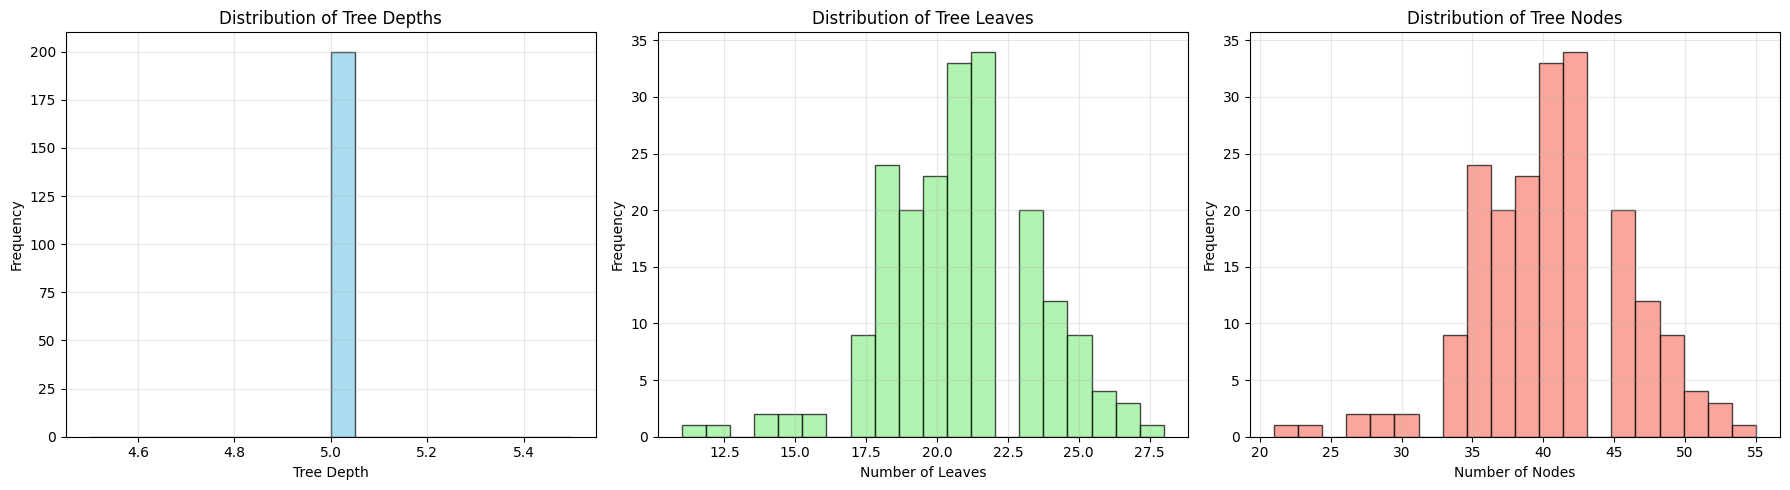

In [53]:
# Plot distributions of tree characteristics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Tree depth distribution
axes[0].hist(tree_depths, bins=20, alpha=0.7, color="skyblue", edgecolor="black")
axes[0].set_xlabel("Tree Depth")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Tree Depths")
axes[0].grid(True, alpha=0.3)

# Tree leaves distribution
axes[1].hist(tree_leaves, bins=20, alpha=0.7, color="lightgreen", edgecolor="black")
axes[1].set_xlabel("Number of Leaves")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Tree Leaves")
axes[1].grid(True, alpha=0.3)

# Tree nodes distribution
axes[2].hist(tree_nodes, bins=20, alpha=0.7, color="salmon", edgecolor="black")
axes[2].set_xlabel("Number of Nodes")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Distribution of Tree Nodes")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6. Single Tree Detailed Visualization

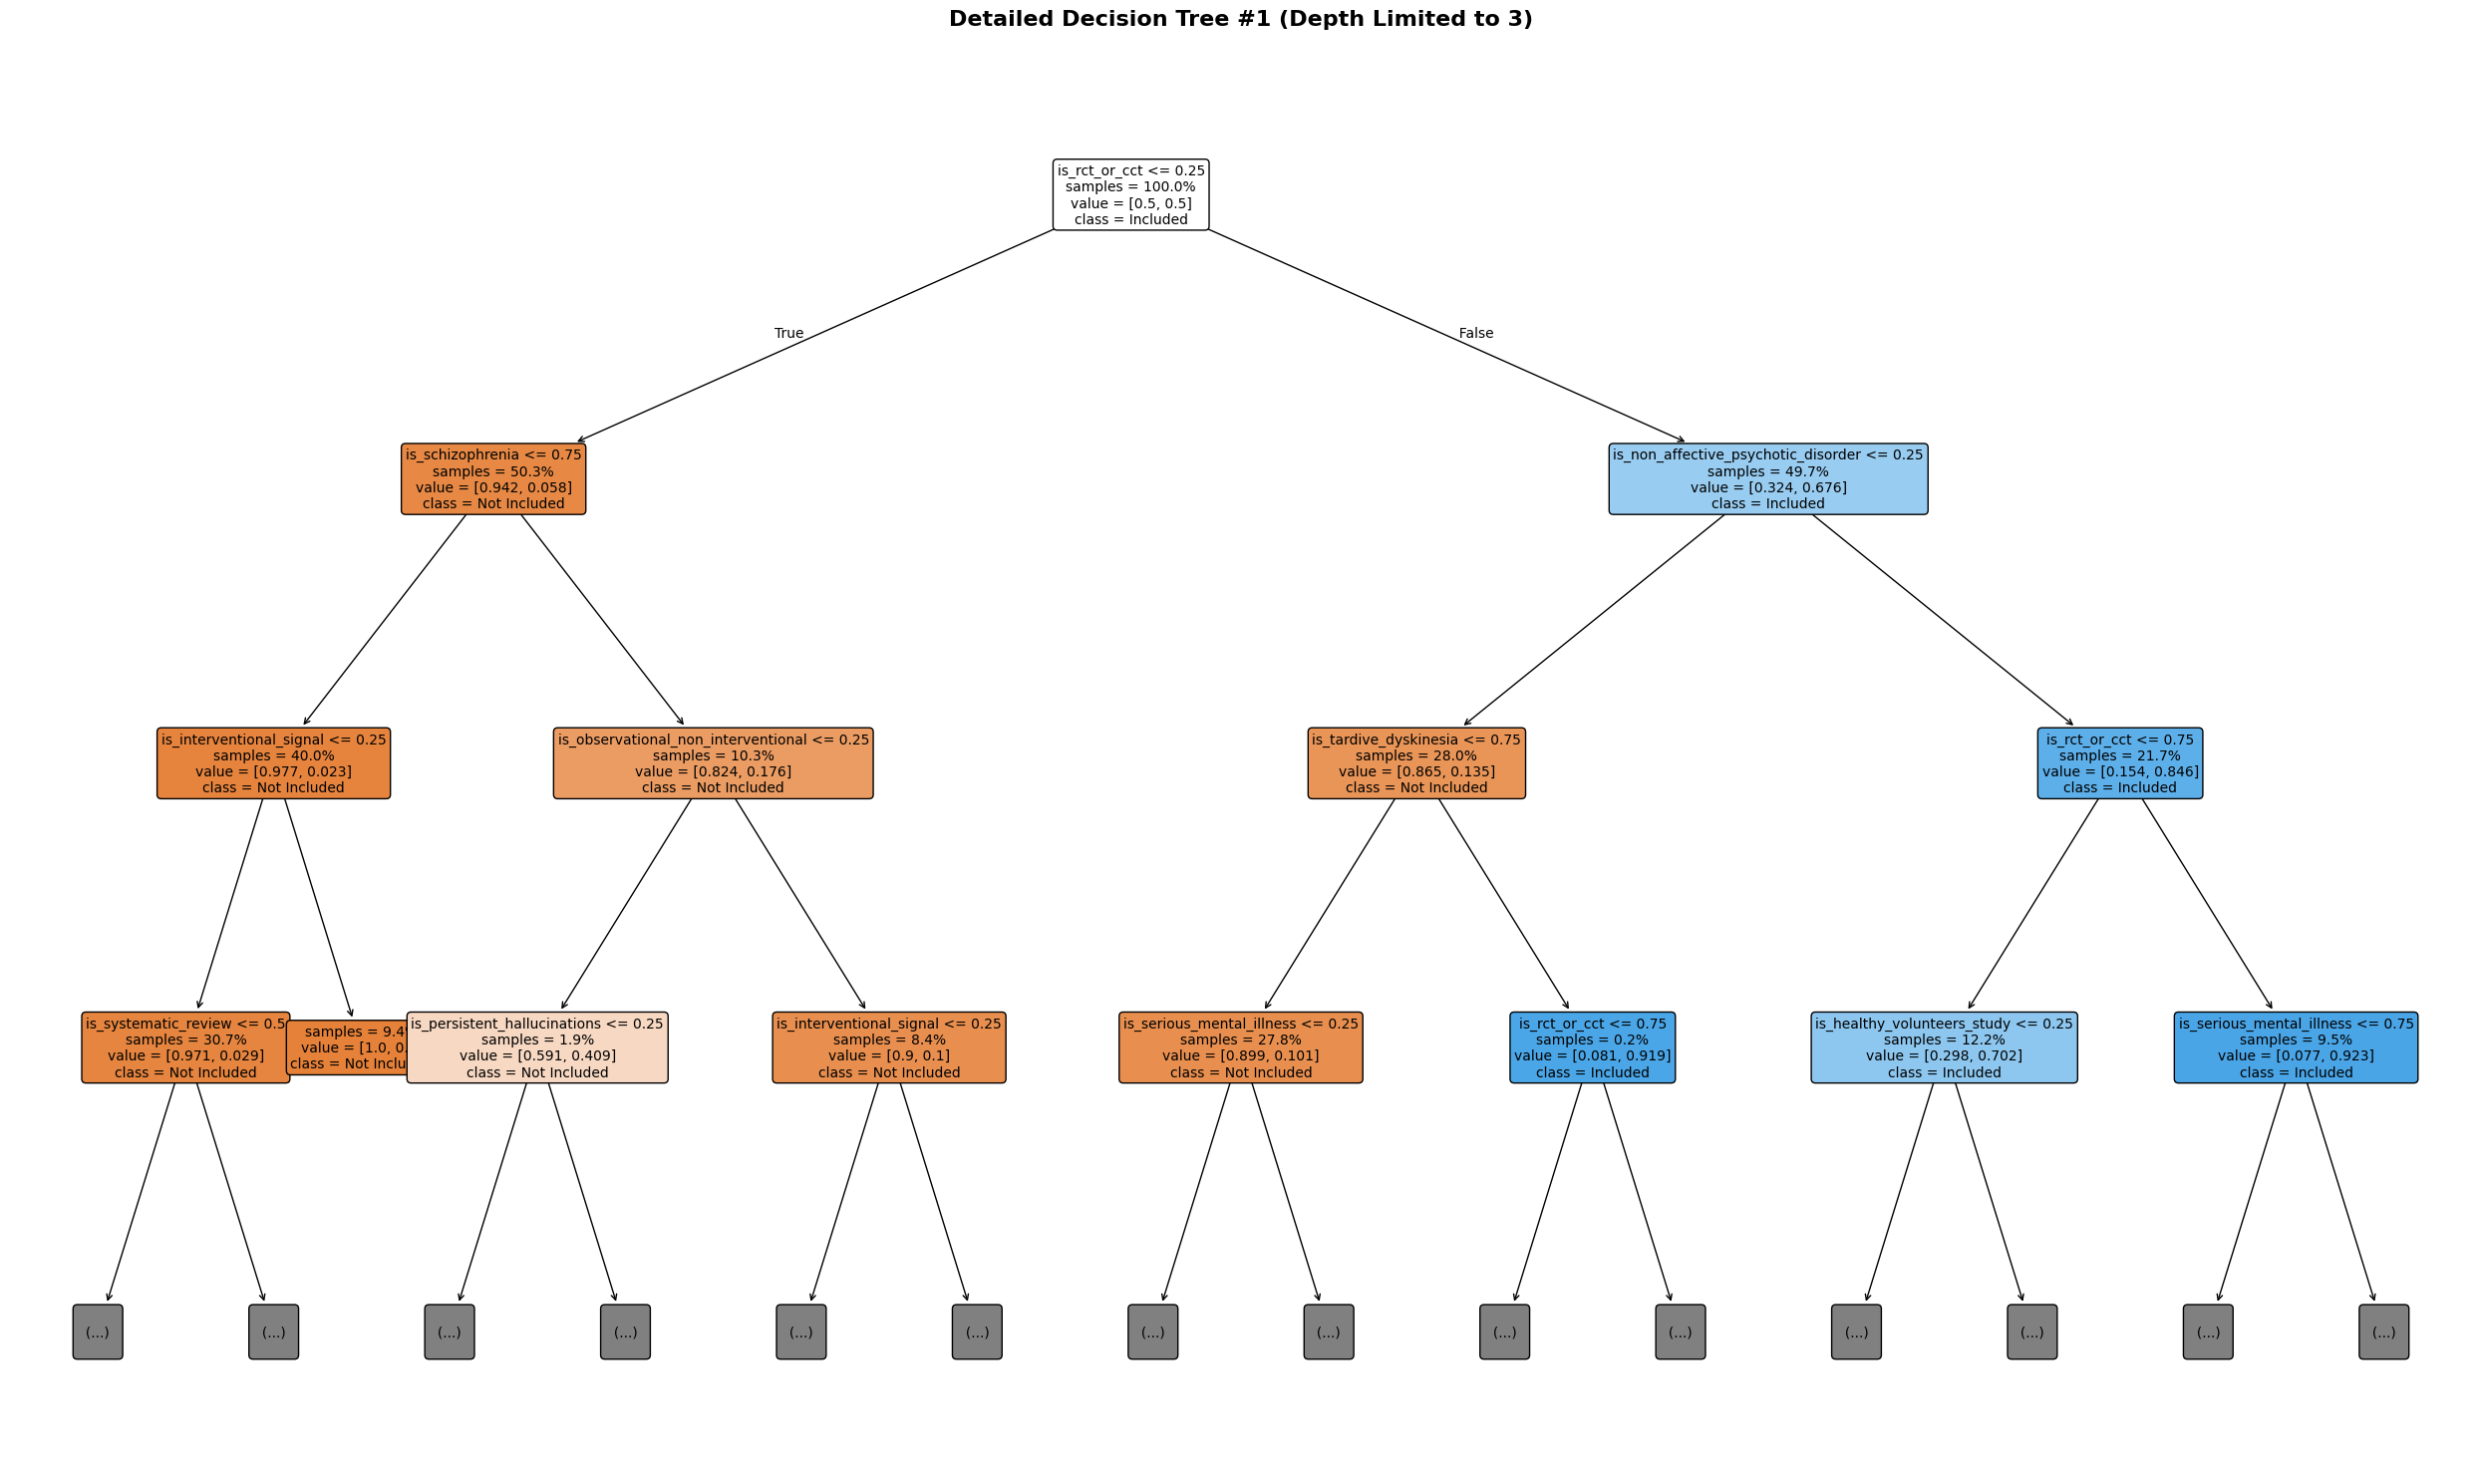

In [54]:
max_depth = 3

# detailed visualization of a single tree with more depth
plt.figure(figsize=(25, 15))

tree_to_plot = classifier.estimators_[0]

plot_tree(
    tree_to_plot,
    feature_names=features_cols,
    class_names=["Not Included", "Included"],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3,
    proportion=True,
    impurity=False,
)
plt.title(f"Detailed Decision Tree #1 (Depth Limited to {max_depth})", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()
plt.show()